# Lab 5: kNN and Naive Bayes

**Before you Start** This lab involves some computing on modest datasets. You should set your VM to use at least 1.5 GB of RAM. If that's not possible, you'll have to shrink the datasets (reduce their number of columns) to be able to run it.

Once you've checked memory size and restarted if needed, grab the lab from the icon at the top right. 

For this lab, we'll use a dataset of hand-written digit images called MNIST. You can download the dataset from <a href="https://github.com/data-boss/Data-Science/blob/main/MNIST.tar.gz">here</a>.  Put it in a lab5 directory, and do:
<pre>
tar xvzf MNIST.tar.gz
</pre>
which will produce an MNIST subdirectory with several files. The data comprises a train and test set, and train and test labels (ictrain and ictest). 

We'll be using numpy for this part of the lab so lets import it:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We can read matrices in text format with numpy's loadtxt command. Text file input is slow, so this may take a few seconds.

In [3]:
train0=np.loadtxt("train.fmat.txt")

Lets look at the shape of this matrix:

In [4]:
train0.shape

(784, 4000)

The columns of the matrix are 28 * 28 images. Since we had to read the data from a 2d array, the structure is different. Lets look at one of the images. We'll also convert it to a matrix, so that more mathematical operators are defined on it. If you have trouble running the lab, reduce the dataset size by decreasing the column bound from 4000 below. 

In [5]:
train = np.asmatrix(train0[:,0:4000])

and we'll save the number of training examples for later:

In [6]:
ntrain = train.shape[1];ntrain

4000

We can take any of the columns of the array, and reshape it to a 28 x 28 matrix:

In [7]:
img = train[:,0].reshape([28,28])

To look at the image, we can use Matplotlib's imshow function. We give it the image, plus a color map which maps the data values 0..255 to grayscale colors:

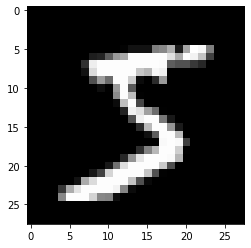

In [8]:
plt.imshow(img,cmap='gray')

Try some different images:

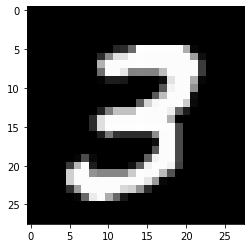

In [9]:
img2 = train[:,7].reshape([28,28])
plt.imshow(img2,cmap='gray')

> TODO: Now create a 10x10 array of the first 100 images and show it below. Its probably easiest to make a 280 x 280 array, and fill it with the individual images. Be sure to scale your displayed image so that it is big enough to see individual images. i.e. so that it fills most of the browser window. 

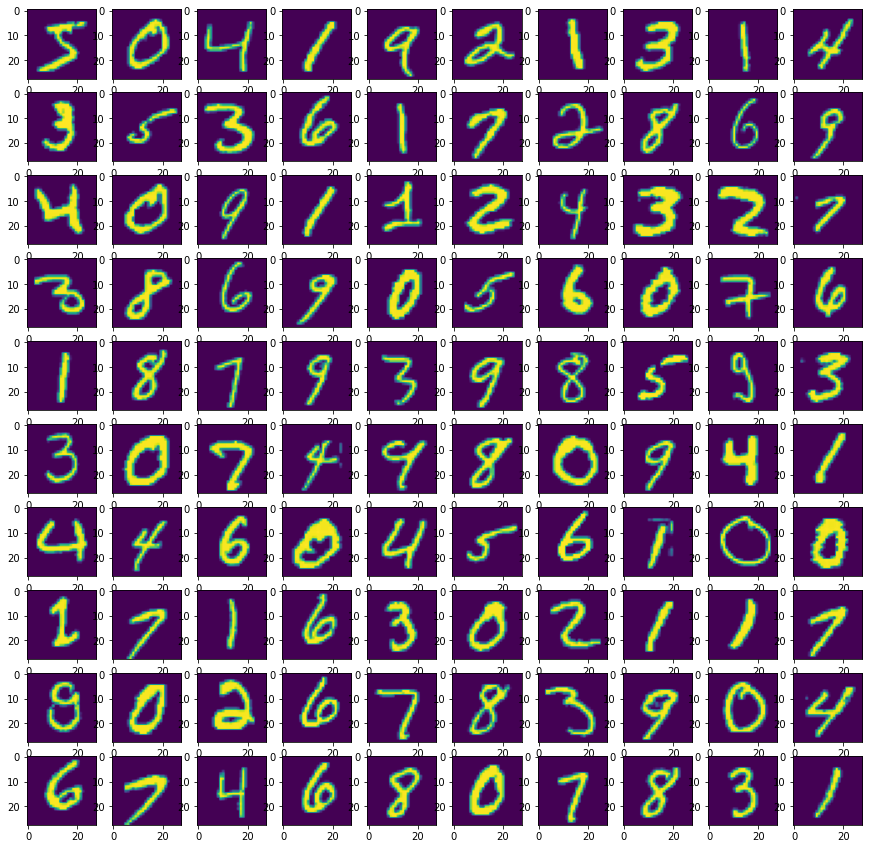

In [14]:
fig=plt.figure(figsize=(15,15))
columns=10
rows=10
images=train[:,0:100]
for i in range(0,columns*rows):
    image=images[:,i].reshape([28,28])
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
plt.show()   

## Computing Test/Train Set Distances

Next we need to compute the pairwise distances between our test and training set. Check the test set dims:

In [15]:
test0=np.loadtxt("test.fmat.txt")
test=test0[:,0:2000]
ntest=test.shape[1];ntest

2000

The squared euclidean distance between two vector x and y is the squared length of their difference. We can write it as
<pre>(x-y) dot (x-y)</pre>
When working with matrices, we can also use a matrix formula, which is
<pre>transpose(x-y) * (x-y)</pre>
Well use the shorthand ".T" for the transpose, and then we can write:
<pre>(x-y) dot (x-y) = x dot x - 2 x.T * y + y dot y</pre>
This formula works for x and y which are single columns. We chose this combination of dot and transpose product so we can generalize it to matrices of points.

We would like to efficiently compute a ntest x ntrain matrix of all pairwise distances using this formula. The first term should be the x dot products, which we can compute like this:

In [16]:
xdots = np.sum(np.multiply(test,test),0).reshape(ntest,1) * np.ones((1,ntrain))

Note that we had to multiply by a row-vector of ones to reproduce the x-product for each y. The formula for y dot products is similar:

In [17]:
ydots = np.ones((ntest, 1)) * np.sum(np.multiply(train,train),0).reshape(1,ntrain) 

Finally, we can complete the distance formula by adding the cross-terms:

In [18]:
dists = xdots + ydots - 2 * np.transpose(test) * train

The raw distances will be larger for larger input instances, which is not what we want. We can improve the distance estimate by normalizing by the lengths of test and train instances:

In [20]:
dists[0,:10]

matrix([[5739837., 7025841., 5795133., 6536253., 5500006., 6093159.,
         5652340., 6993727., 4700000., 5134448.]])

> TODO: produce a normalized distance matrix ndists by dividing by the eucliden length of the test and train points. Hint: you already have the squared euclidean lengths of all the test and train points.

In [21]:
ndists = np.divide(dists,np.add(xdots,ydots))

Now the i^th row of the distance matrix is the vector of distances from the i^th test point to the training points. To get the closest neighbors, we can sort this array along its rows (axis = 1). The argsort function returns the index of the closest points, which we can use to lookup their label. 

In [22]:
ibest = np.argsort(ndists,axis=1); ibest

matrix([[1673,  522, 3324, ..., 1131,  941, 1080],
        [1609, 1874, 2738, ..., 1031,  770, 1190],
        [1697, 2301, 1658, ...,  608, 3747,  742],
        ...,
        [1130,   98, 1144, ...,  770,  294, 1440],
        [3678,  350, 1960, ...,  828, 1102, 3734],
        [3170, 3870, 1556, ..., 2551, 2461, 1440]])

To look up the distances along a given row, we can use the ibest array to provide the column (training point) indices. 

In [23]:
irow = 0
ndists[irow,ibest[irow,:]]

matrix([[0.14616176, 0.14787672, 0.14990902, ..., 0.91195751, 0.91320307,
         0.913357  ]])

And then to get their labels we should load the label data matrix:

In [24]:
labels = np.loadtxt("ictrain.imat.txt")

In [25]:
labels[ibest[irow,:]]

array([[7., 7., 7., ..., 1., 1., 1.]])

> TODO: What label is the best match for test point 0? Give as answer to question 2 in response form

Now we'll restrict ourselves to the k-nearest neighbors. We currently have all the neighbors as columns of the dists and ibest matrices. Lets produce the labels of only the k-nearest, which is simply:

In [ ]:
k = 3

In [26]:
knlabels = labels[ibest]; knlabels

array([[7., 7., 7., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 6., 6.],
       [1., 1., 1., ..., 7., 7., 4.],
       ...,
       [3., 3., 3., ..., 6., 4., 4.],
       [9., 9., 9., ..., 4., 0., 0.],
       [5., 5., 5., ..., 5., 5., 4.]])

to get the k-nearest distances, we can sort the distances directly:

In [27]:
ndists[0,ibest[0,:]]

matrix([[0.14616176, 0.14787672, 0.14990902, ..., 0.91195751, 0.91320307,
         0.913357  ]])

Now, lets find the majority vote for each label. First we need to count the votes in a matrix whose columns are the possible digits. You'll need to do this with loops, since Python lacks a general accumulate function.

In [28]:
votes = np.zeros((ntest,10))

> TODO: write code to fill out the votes array with the predicted labels using the k nearest neighbors

In [30]:
k=5
for v in range(0,ntest):
    knl=knlabels[v,:k].astype(int)
    votes[v,np.unique(knl)]=np.unique(knl,return_counts=True)[1]        


Then we can find the position of the maximum of the votes, which will also be the digit label:

In [31]:
bestlabels = np.argmax(votes, axis=1); bestlabels

array([7, 2, 1, ..., 3, 9, 5])

How well did we do? Lets load the test labels and see:

In [32]:
testlabels0 = np.loadtxt("ictest.imat.txt")
testlabels = testlabels0[0:ntest]

We can directly compare the bestlabels (predicted) and the testlabels with == to compute matches. Matching labels will produce a 1 or 0 otherwise. To find the fraction of matches we simply take the mean of the 0-1 values. 

In [33]:
accuracy = np.mean(bestlabels == testlabels); accuracy

0.9135

Now lets try some other values of k. To speed things up, we'll skip the expensive sort steps, which we've already done anyway. 

In [35]:
k = 3

votes = np.zeros((ntest,10))

for v in range(0,ntest):
    knl=knlabels[v,:k].astype(int)
    votes[v,np.unique(knl)]=np.unique(knl,return_counts=True)[1]   
  
bestlabels = np.argmax(votes, axis=1)

np.mean(bestlabels == testlabels)

0.913

> TODO: What was the best value of k <= 10? What is the corresponding accuracy? (Question 3 in response form)

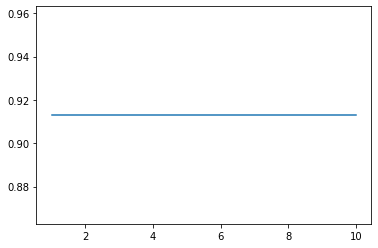

In [37]:
acc=np.zeros(10)
for kn in range(1,11):
    votes=np.zeros((ntest,10))   
    for v in range(0,ntest):
        knl=knlabels[v,:k].astype(int)
        votes[v,np.unique(knl)]=np.unique(knl,return_counts=True)[1] 

    bestlabels = np.argmax(votes, axis=1)

    acc[kn-1]=np.mean(bestlabels == testlabels)

plt.plot(np.arange(1,11),acc)  

In [39]:
acc

array([0.913, 0.913, 0.913, 0.913, 0.913, 0.913, 0.913, 0.913, 0.913,
       0.913])

Now lets try weighting by inverse distance. Modify the last compute cell to use the inverse distance (you probably want to use the kndists matrix) as the vote. 

In [46]:
k = 3

votes = np.zeros((ntest,10))

for n in range(0,ntest):
    knl=knlabels[n,:k].astype(int)
    votes[n,knl]=1/ndists[n,ibest[n,:k]]
    #votes[v,np.unique(knl)]=np.unique(knl,return_counts=True)[1]   

        
bestlabels = np.argmax(votes, axis=1)
np.mean(bestlabels == testlabels)


0.891

> TODO: Now what is the next value of k <= 10? What is the corresponding accuracy? (Question 4)

# Naive Bayes

Read the documentation for Naive Bayes in Scikit-learn here http://scikit-learn.org/stable/modules/naive_bayes.html
This section uses Scikit-learn, which is installed on your VM. Unfortunately, this module depends on nose tests, which arent installed. Go to a shell prompt and type:
<pre>
sudo pip install nose
</pre>

We want to classify our image data, and so we have to choose a feature distribution. Although the data for MNIST are real 0..255 brightness values, most values are either 0's or 255's so we'll threshold them to produce binary features. Then we can use the Bernoulli Naive Bayes classifier. 

We also need to transpose the data: Sckikit-learn expects data points to be rows rather than columns.

In [47]:
btrain = np.transpose(train > 128)
btest = np.transpose(test > 128)

Now import the BernoulliNB classifier:

In [48]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()

Which creates a new Bernoulli Naive Bayes classifier. Now train the classifier on your binarized training data. 

In [49]:
model = nb.fit(btrain, labels)

Use the model to predict the labels of the binarized test data:

In [50]:
nbpreds = model.predict(btest)

And evaluate the predictions compared to the actual labels

In [51]:
np.mean(nbpreds == testlabels)

0.7805

> TODO: How did the accuracy of Naive Bayes compare with the kNN classifier on this data? (Question 5)

> TODO: How well do you think this dataset fits the assumptions of the kNN and Naive Bayes models respectively? (Question 6)

# Diagnosing Performance: Confusion Matrices

Lets dig a bit deeper into the results from both classifiers. One useful tool is a confusion matrix: this is a matrix index by the true labels and predicted labels, and holds the normalized counts of values in each element. We can form the matrix as follows:

We start with a matrix C such that C[i,j] is a count of the points with predicted label i and true label j. We then normalize C so that its columns add up to 1. Then the j^th column corresponds to true label j, and is a vector of the probabilities that a true label of j is classified as one of the other labels. 

In [52]:
def confCount(a0, b0):
    a = a0.astype('int64')
    b = b0.astype('int64')
    counts = np.zeros((10,10))
    for i in range(0,a.size):
        counts[b[i],a[i]] += 1
    return counts           
            

In the cell below, we compute the confusion matrix for the Naive Bayes classifier. 

In [53]:
ccounts = confCount(testlabels, nbpreds)
conf = ccounts / sum(ccounts).reshape(10,1)
conf

array([[0.85714286, 0.        , 0.01142857, 0.        , 0.00571429,
        0.02857143, 0.02857143, 0.        , 0.00571429, 0.00571429],
       [0.        , 0.95726496, 0.03418803, 0.01709402, 0.00854701,
        0.00854701, 0.01282051, 0.05555556, 0.01709402, 0.0042735 ],
       [0.00456621, 0.        , 0.75342466, 0.00456621, 0.        ,
        0.00913242, 0.0456621 , 0.02283105, 0.02283105, 0.        ],
       [0.        , 0.        , 0.04830918, 0.79227053, 0.        ,
        0.11594203, 0.        , 0.        , 0.09661836, 0.01932367],
       [0.        , 0.        , 0.00460829, 0.00460829, 0.75576037,
        0.02764977, 0.04608295, 0.03225806, 0.02764977, 0.09677419],
       [0.05027933, 0.03351955, 0.00558659, 0.07821229, 0.00558659,
        0.67597765, 0.03910615, 0.00558659, 0.0726257 , 0.01117318],
       [0.03932584, 0.01123596, 0.04494382, 0.02247191, 0.03370787,
        0.01685393, 0.78651685, 0.        , 0.01123596, 0.        ],
       [0.        , 0.        , 0.0243902

> TODO: Now in the cell below create a grayscale visualization of the confusion matrix. i.e. a 10 x 10 image whose elements are in the range 0..255 and are 255 times the values of the confusion matrix. 

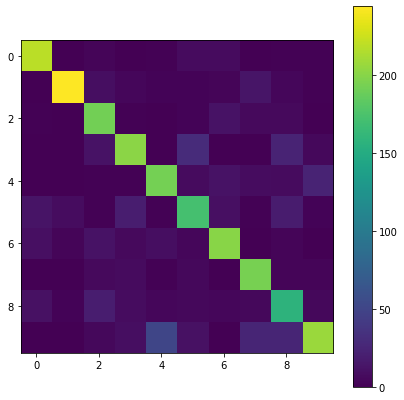

In [54]:
nconf=conf*255
fig=plt.figure(figsize=(7,7))
plt.imshow(nconf)
plt.colorbar()

> TODO: Using the vizualization or the matrix itself, answer these questions:

> Q7: which digit is misclassified most often? How did you derive your answer from the confusion matrix?

> Q8: How many mislabeled pairs are there (a pair of correct digit, incorrect label) which have probability > 0.05 ? 

In [60]:
a=np.ones((10,10))
np.fill_diagonal(a,0)
mis_p=np.multiply(conf,a)
np.unique(mis_p>0.05,return_counts=True)

(array([False,  True]), array([89, 11]))

## Lab Responses

Enter your lab responses <a href="https://forms.office.com/Pages/ResponsePage.aspx?id=bAnfdXKL5Eibkcv3nYfuOlHhusHecfNNjSokZ153wqVUMlIwSjBYUklZQlZVT0g3MjRISDdTUzBEMy4u">here</a>